In [1]:
#Essential Constants
from scipy.constants import h, c, hbar, u, k

#Imports from other script/s
from ipynb.fs.full.Conversions_Epimetheus import * #Conversion Doc
from ipynb.fs.full.Atomic_Mass_Key import element #Mass Key File
from ipynb.fs.full.EpiPan_Functions import * #All Functions

#General Imports
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
import itertools
import pandas as pd

/Users/thomascross/opt/anaconda3/lib/python3.8/site-packages/pyscf/dft/libxc.py:771: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, corresponding to the original definition by Stephens et al. (issue 1480) and the same as the B3LYP functional in Gaussian. To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


In [2]:
#Import Desired PES
#DAWES == 13DaLo
from ipynb.fs.full.O3_PES_fortran_DAWES import PES

In [3]:
#Imported "PRIME" Data // HITRAN2020
prime_link = "https://hitran.org/results/670cd55e.out"
if type(prime_link) == str:
    prime_data = pd.read_csv(prime_link, header=None, skiprows=None, sep=",")     
    prime_data.to_csv("O3_SPEC_HITRAN2020.csv")
    
    prime_freq = prime_data.loc[:,0]
    prime_freq = np.array(prime_freq)
    
    prime_intensity = prime_data.loc[:,1]
    prime_intensity = np.array(prime_intensity)
    prime_intensity = np.divide(prime_intensity, sum(prime_intensity))
    
elif prime_link == 1: 
    prime_data = pd.read_csv("O3_SPEC_HITRAN2020.csv", sep=",", header=None, skiprows=1)

    prime_freq = prime_data.loc[:,1]
    prime_freq = np.array(prime_freq)
    
    prime_intensity = prime_data.loc[:,2]
    prime_intensity = np.array(prime_intensity)
    prime_intensity = np.divide(prime_intensity, sum(prime_intensity))

### Manual Inputs

In [4]:
#Temperature
T = 300

In [5]:
molecule = ["O", "O", "O"]

In [6]:
#Positions/Bond Lengths/Angles
r1 = 1.28
r2 = r1
alpha = 116.78 
#Fortran values
r1 =1.27200
r2 = r1
alpha =116.7800
coord = coord_triatomic(alpha, r1, r2)
#coord = geo_opt(coord, molecule)

In [7]:
mass = ((element["O"] * u * kg_to_me), 
            (element["O"] * u * kg_to_me), 
            (element["O"] * u * kg_to_me))

In [8]:
B, I, COMcoord = rot_inertia_rcom(coord, mass)

R_com [0.        0.4444661 0.       ]
r_COMalpha [[-1.08328032  0.22223305  0.        ]
 [ 0.         -0.4444661   0.        ]
 [ 1.08328032  0.22223305  0.        ]]


### Calculations 

In [9]:
Key, Pos =  Key_and_Pos(coord)

In [10]:
PES_func = PES(Key, Pos, molecule)

In [11]:
Hess = Hess_CART(Key, Pos, PES, molecule)

In [12]:
Hess_MWC_fin = Hess_MWC(Hess, Key, mass)

In [13]:
eigvals, eigvecs, Hess_diag_au, Hess_diag_wn, fundamentals_au, fundamentals_wn = eigval_eigvec(Hess_MWC_fin)

In [14]:
eigvecs_UMW = UMW(eigvecs, mass, Key)

In [15]:
displace_vec, displace_val= displace_vec_and_val(eigvals, eigvecs_UMW)

In [16]:
cubic = cubic_CART(Key, Pos, displace_vec, displace_val, PES, molecule)

In [17]:
quartic = quartic_CART(Key, Pos, displace_vec, displace_val, PES, molecule)

In [18]:
sigma = sigma_ij(displace_val, cubic)

In [19]:
deltaETOSH = deltaETOSH_ij(displace_val, cubic, quartic, sigma)

In [20]:
allrot = all_rot_const(displace_vec, sigma, coord, mass, bohr_to_angstrom)

R_com [-1.25541060e-07  4.44464938e-01 -9.60789620e-20]
r_COMalpha [[-1.08657395e+00  2.20552233e-01 -1.77823384e-19]
 [-1.01684969e-02 -4.47355393e-01  8.15961367e-20]
 [ 1.09674245e+00  2.26803160e-01  9.62272470e-20]]
R_com [-4.15907898e-17  4.44466100e-01  3.66050084e-30]
r_COMalpha [[-1.08328032e+00  2.22233050e-01  3.33770976e-30]
 [ 1.54138208e-12 -4.44466100e-01  3.81527067e-31]
 [ 1.08328032e+00  2.22233050e-01 -3.71923683e-30]]
R_com [-7.82509187e-08  4.44464892e-01 -1.89024957e-20]
r_COMalpha [[-1.08689982e+00  2.21139369e-01 -2.10879175e-20]
 [-6.33811938e-03 -4.46174999e-01  2.04628802e-21]
 [ 1.09323794e+00  2.25035630e-01  1.90416294e-20]]


In [37]:
key_data = data_file_maker_triatomic(displace_val, deltaETOSH, B, allrot, "O3_666_13DaLo_specconst")

   harmonic_wn  anharmonic_wn     B_000   B_Freq1   B_Freq2   B_Freq3
0  1122.417396    1101.741406  3.556691  3.511714  3.556691  3.529818
1  1089.613263    1039.003184  0.449059  0.442147  0.449059  0.443465
2   708.702832     690.752686  0.398717  0.392703  0.398717  0.393969


In [22]:
J_max_arr, A_rot, B_rot, C_rot = J_max_func(B, T)

In [23]:
P_nu1, P_rot_nu1, P_index_nu1 = asytop_v_P(1, J_max_arr, "B", deltaETOSH[0] , A_rot, allrot[0][0], B_rot, allrot[0][1], C_rot, allrot[0][2])

Q_nu1, Q_rot_nu1, Q_index_nu1 = asytop_v_Q(1, J_max_arr, "B", deltaETOSH[0] , A_rot, allrot[0][0], B_rot, allrot[0][1], C_rot, allrot[0][2])

R_nu1, R_rot_nu1, R_index_nu1 = asytop_v_R(1, J_max_arr, "B", deltaETOSH[0] , A_rot, allrot[0][0], B_rot, allrot[0][1], C_rot, allrot[0][2])
##

100%|██████████| 72/72 [00:11<00:00,  6.41it/s] 


In [24]:
P_nu2, P_rot_nu2, P_index_nu2 = asytop_v_P(1, J_max_arr, "B", deltaETOSH[2] , A_rot, allrot[2][0], B_rot, allrot[2][1], C_rot, allrot[2][2])

Q_nu2, Q_rot_nu2, Q_index_nu2 = asytop_v_Q(1, J_max_arr, "B", deltaETOSH[2] , A_rot, allrot[2][0], B_rot, allrot[2][1], C_rot, allrot[2][2])

R_nu2, R_rot_nu2, R_index_nu2 = asytop_v_R(1, J_max_arr, "B", deltaETOSH[2] , A_rot, allrot[2][0], B_rot, allrot[2][1], C_rot, allrot[2][2])
##

100%|██████████| 72/72 [00:11<00:00,  6.36it/s] 


In [25]:
P_nu3, P_rot_nu3, P_index_nu3 = asytop_v_P(2, J_max_arr, "A", deltaETOSH[1] , A_rot, allrot[1][0], B_rot, allrot[1][1], C_rot, allrot[1][2])

Q_nu3, Q_rot_nu3, Q_index_nu3 = asytop_v_Q(2, J_max_arr, "A", deltaETOSH[1] , A_rot, allrot[1][0], B_rot, allrot[1][1], C_rot, allrot[1][2])

R_nu3, R_rot_nu3, R_index_nu3 = asytop_v_R(2, J_max_arr, "A", deltaETOSH[1] , A_rot, allrot[1][0], B_rot, allrot[1][1], C_rot, allrot[1][2])
##

100%|██████████| 72/72 [00:11<00:00,  6.37it/s] 


In [26]:
nu1_I = Norm_I(P_rot_nu1, P_index_nu1, Q_rot_nu1, Q_index_nu1, R_rot_nu1, R_index_nu1, T, 1, 0.039)
##

In [27]:
nu2_I = Norm_I(P_rot_nu2, P_index_nu2, Q_rot_nu2, Q_index_nu2, R_rot_nu2, R_index_nu2, T, 1, 0.047)
##

In [28]:
nu3_I = Norm_I(P_rot_nu3, P_index_nu3, Q_rot_nu3, Q_index_nu3, R_rot_nu3, R_index_nu3, T, 1, 1)
##

In [29]:
Final_I = Fin_I(nu1_I[0], nu1_I[1],nu1_I[2], nu2_I[0], nu2_I[1], nu2_I[2], nu3_I[0], nu3_I[1], nu3_I[2])
##

In [30]:
#All taken from "The ozone molecule: infrared and microwave spectroscopy"
# by J. M. Flaud and R. Bacis, 1997
exp_B = (3.553667, 0.445283, 0.394752)
exp_J_max_arr, exp_A_rot, exp_B_rot, exp_C_rot = J_max_func(exp_B, T)

mode_100 = 1103.137
A_mode_100 = 3.556694
B_mode_100 = 0.442736 
C_mode_100 = 0.392568

exp_P_nu1, exp_P_rot_nu1, exp_P_index_nu1 = asytop_v_P(1, exp_J_max_arr, "B", mode_100 , exp_A_rot, A_mode_100, exp_B_rot, B_mode_100, exp_C_rot, C_mode_100)
exp_Q_nu1, exp_Q_rot_nu1, exp_Q_index_nu1 = asytop_v_Q(1, exp_J_max_arr, "B", mode_100 , exp_A_rot, A_mode_100, exp_B_rot, B_mode_100, exp_C_rot, C_mode_100)
exp_R_nu1, exp_R_rot_nu1, exp_R_index_nu1 = asytop_v_R(1, exp_J_max_arr, "B", mode_100 , exp_A_rot, A_mode_100, exp_B_rot, B_mode_100, exp_C_rot, C_mode_100)

mode_010 = 700.931
A_mode_010 = 3.607092
B_mode_010 = 0.444022 
C_mode_010 = 0.392439

exp_P_nu2, exp_P_rot_nu2, exp_P_index_nu2 = asytop_v_P(1, exp_J_max_arr, "B", mode_010 , exp_A_rot, A_mode_010, exp_B_rot, B_mode_010, exp_C_rot, C_mode_010)
exp_Q_nu2, exp_Q_rot_nu2, exp_Q_index_nu2 = asytop_v_Q(1, exp_J_max_arr, "B", mode_010 , exp_A_rot, A_mode_010, exp_B_rot, B_mode_010, exp_C_rot, C_mode_010)
exp_R_nu2, exp_R_rot_nu2, exp_R_index_nu2 = asytop_v_R(1, exp_J_max_arr, "B", mode_010 , exp_A_rot, A_mode_010, exp_B_rot, B_mode_010, exp_C_rot, C_mode_010)

mode_001 = 1042.084
A_mode_001 = 3.500553 
B_mode_001 = 0.441296 
C_mode_001 = 0.390998

exp_P_nu3, exp_P_rot_nu3, exp_P_index_nu3 = asytop_v_P(2, exp_J_max_arr, "A", mode_001 , exp_A_rot, A_mode_001, exp_B_rot, B_mode_001, exp_C_rot, C_mode_001)
exp_Q_nu3, exp_Q_rot_nu3, exp_Q_index_nu3 = asytop_v_Q(2, exp_J_max_arr, "A", mode_001 , exp_A_rot, A_mode_001, exp_B_rot, B_mode_001, exp_C_rot, C_mode_001)
exp_R_nu3, exp_R_rot_nu3, exp_R_index_nu3 = asytop_v_R(2, exp_J_max_arr, "A", mode_001 , exp_A_rot, A_mode_001, exp_B_rot, B_mode_001, exp_C_rot, C_mode_001)


exp_nu1_I = Norm_I(exp_P_rot_nu1, exp_P_index_nu1, exp_Q_rot_nu1, exp_Q_index_nu1, exp_R_rot_nu1, exp_R_index_nu1, T, 1, 0.039)
##
exp_nu2_I = Norm_I(exp_P_rot_nu2, exp_P_index_nu2, exp_Q_rot_nu2, exp_Q_index_nu2, exp_R_rot_nu2, exp_R_index_nu2, T, 1, 0.047)
##
exp_nu3_I = Norm_I(exp_P_rot_nu3, exp_P_index_nu3, exp_Q_rot_nu3, exp_Q_index_nu3, exp_R_rot_nu3, exp_R_index_nu3, T, 1, 1)
##
exp_Final_I = Fin_I(exp_nu1_I[0], exp_nu1_I[1], exp_nu1_I[2], exp_nu2_I[0], exp_nu2_I[1], exp_nu2_I[2], exp_nu3_I[0], exp_nu3_I[1], exp_nu3_I[2])

##

100%|██████████| 72/72 [00:11<00:00,  6.38it/s] 


In [31]:
harm_B = (B[0], B[1], B[2])
harm_J_max_arr, harm_A_rot, harm_B_rot, harm_C_rot = J_max_func(harm_B, T)

harm_P_nu1, harm_P_rot_nu1, harm_P_index_nu1 = asytop_v_P(1, harm_J_max_arr, "B", fundamentals_wn[0] , harm_A_rot, harm_A_rot, harm_B_rot, harm_B_rot, harm_C_rot, harm_C_rot)
harm_Q_nu1, harm_Q_rot_nu1, harm_Q_index_nu1 = asytop_v_Q(1, harm_J_max_arr, "B", fundamentals_wn[0] , harm_A_rot, harm_A_rot, harm_B_rot, harm_B_rot, harm_C_rot, harm_C_rot)
harm_R_nu1, harm_R_rot_nu1, harm_R_index_nu1 = asytop_v_R(1, harm_J_max_arr, "B", fundamentals_wn[0] , harm_A_rot, harm_A_rot, harm_B_rot, harm_B_rot, harm_C_rot, harm_C_rot)

harm_P_nu2, harm_P_rot_nu2, harm_P_index_nu2 = asytop_v_P(1, harm_J_max_arr, "B", fundamentals_wn[2] , harm_A_rot, harm_A_rot, harm_B_rot, harm_B_rot, harm_C_rot, harm_C_rot)
harm_Q_nu2, harm_Q_rot_nu2, harm_Q_index_nu2 = asytop_v_Q(1, harm_J_max_arr, "B", fundamentals_wn[2] , harm_A_rot, harm_A_rot, harm_B_rot, harm_B_rot, harm_C_rot, harm_C_rot)
harm_R_nu2, harm_R_rot_nu2, harm_R_index_nu2 = asytop_v_R(1, harm_J_max_arr, "B", fundamentals_wn[2] , harm_A_rot, harm_A_rot, harm_B_rot, harm_B_rot, harm_C_rot, harm_C_rot)

harm_P_nu3, harm_P_rot_nu3, harm_P_index_nu3 = asytop_v_P(2, harm_J_max_arr, "A", fundamentals_wn[1] , harm_A_rot, harm_A_rot, harm_B_rot, harm_B_rot, harm_C_rot, harm_C_rot)
harm_Q_nu3, harm_Q_rot_nu3, harm_Q_index_nu3 = asytop_v_Q(2, harm_J_max_arr, "A", fundamentals_wn[1] , harm_A_rot, harm_A_rot, harm_B_rot, harm_B_rot, harm_C_rot, harm_C_rot)
harm_R_nu3, harm_R_rot_nu3, harm_R_index_nu3 = asytop_v_R(2, harm_J_max_arr, "A", fundamentals_wn[1] , harm_A_rot, harm_A_rot, harm_B_rot, harm_B_rot, harm_C_rot, harm_C_rot)


harm_nu1_I = Norm_I(harm_P_rot_nu1, harm_P_index_nu1, harm_Q_rot_nu1, harm_Q_index_nu1, harm_R_rot_nu1, harm_R_index_nu1, T, 1, 0.039)
##
harm_nu2_I = Norm_I(harm_P_rot_nu2, harm_P_index_nu2, harm_Q_rot_nu2, harm_Q_index_nu2, harm_R_rot_nu2, harm_R_index_nu2, T, 1, 0.047)
##
harm_nu3_I = Norm_I(harm_P_rot_nu3, harm_P_index_nu3, harm_Q_rot_nu3, harm_Q_index_nu3, harm_R_rot_nu3, harm_R_index_nu3, T, 1, 1)
##
harm_Final_I = Fin_I(harm_nu1_I[0], harm_nu1_I[1], harm_nu1_I[2], harm_nu2_I[0], harm_nu2_I[1], harm_nu2_I[2], harm_nu3_I[0], harm_nu3_I[1], harm_nu3_I[2])

100%|██████████| 72/72 [00:15<00:00,  4.58it/s]


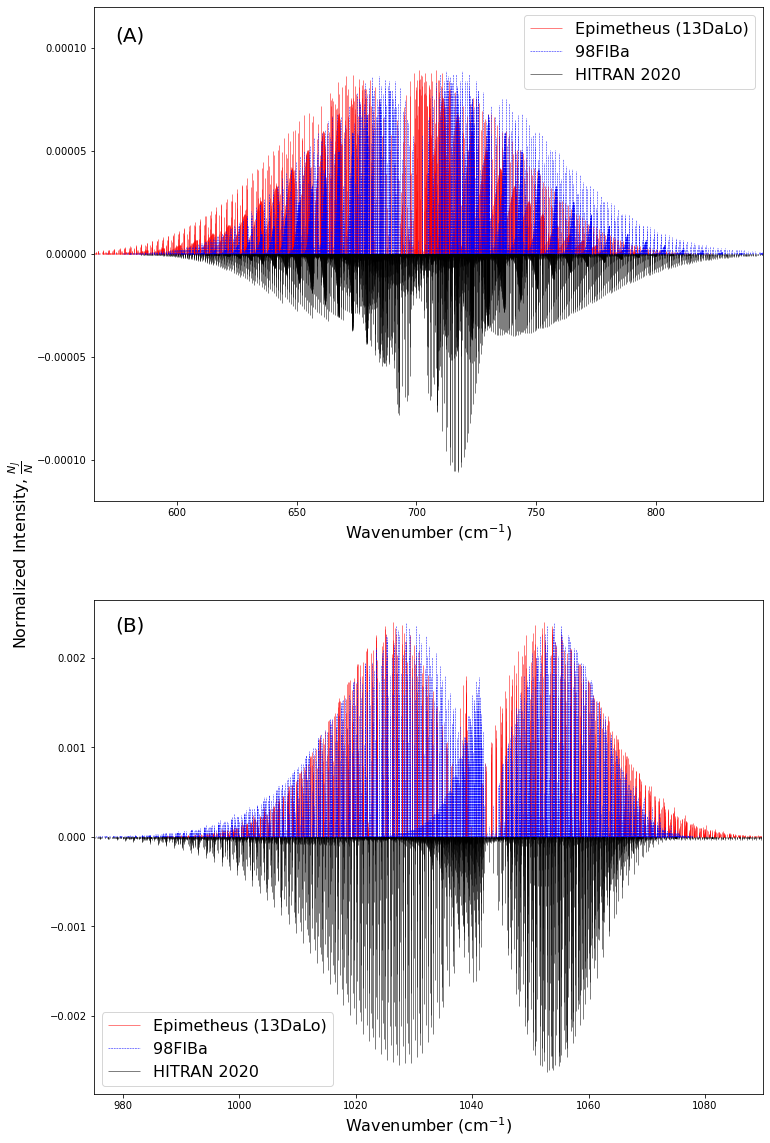

In [32]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex="row", figsize=(12,20))

#AX1


ax1.vlines(P_nu2, 0, Final_I[3], "red",label="Epimetheus (13DaLo)", linewidth=.5)
ax1.vlines(Q_nu2, 0, Final_I[4], "red", linewidth=.5)
ax1.vlines(R_nu2, 0, Final_I[5], "red", linewidth=.5)

ax1.vlines(exp_P_nu2, 0, exp_Final_I[3], "blue",linestyle='dashed',  label="98FlBa", linewidth=.5)
ax1.vlines(exp_Q_nu2, 0, exp_Final_I[4], "blue",linestyle='dashed', linewidth=.5)
ax1.vlines(exp_R_nu2, 0, exp_Final_I[5], "blue",linestyle='dashed', linewidth=.5)

ax1.vlines(prime_freq,0, -prime_intensity, color="k", label="HITRAN 2020", linewidth=.5)

#AX2

ax2.vlines(P_nu3, 0, Final_I[6], "red",label="Epimetheus (13DaLo)", linewidth=.5)
ax2.vlines(Q_nu3, 0, Final_I[7], "red", linewidth=.5)
ax2.vlines(R_nu3, 0, Final_I[8], "red", linewidth=.5)

ax2.vlines(exp_P_nu3, 0, exp_Final_I[6], "blue",linestyle='dashed',label="98FlBa", linewidth=.5)
ax2.vlines(exp_Q_nu3, 0, exp_Final_I[7], "blue",linestyle='dashed', linewidth=.5)
ax2.vlines(exp_R_nu3, 0, exp_Final_I[8], "blue",linestyle='dashed', linewidth=.5)

ax2.vlines(prime_freq,0, -prime_intensity, color="k", label="HITRAN 2020", linewidth=.5)

ax1.set_xlim(565, 845)
ax1.set_ylim(-.00012, .00012)
ax2.set_xlim(975, 1090)
#plt.subplots_adjust(wspace=0, hspace=0)

fig.text(0.025, 0.5, r"Normalized Intensity, $\frac{N_J}{N}$", va='center', rotation='vertical', fontsize=16)

fig.text(0.15, 0.86, "(A)", va='center', fontsize=20)

fig.text(0.15, 0.45, "(B)", va='center', fontsize=20)

ax1.set_xlabel(r"Wavenumber (cm$^{-1}$)", fontsize=16)
ax2.set_xlabel(r"Wavenumber (cm$^{-1}$)", fontsize=16)

ax1.legend(loc='best', fontsize=16)
ax2.legend(loc='lower left', fontsize=16)

plt.savefig(f"EPI_O3_666_13DaLo_010_001_highspec_HITRAN_subplots_{T}K.pdf")

plt.show()

In [ ]:
plt.figure(figsize=(16,8))
plt.vlines(prime_freq,0, -prime_intensity, color="k", label="HITRAN 2020", linewidth=.5)

plt.vlines(P_nu1, 0, Final_I[0], "coral", label="Mode 100 (13DaLo)", linewidth=.5)
plt.vlines(Q_nu1, 0, Final_I[1], "coral", linewidth=.5)
plt.vlines(R_nu1, 0, Final_I[2], "coral", linewidth=.5)

plt.vlines(P_nu2, 0, Final_I[3], "orangered", label="Mode 010 (13DaLo)",linewidth=.5)
plt.vlines(Q_nu2, 0, Final_I[4], "orangered", linewidth=.5)
plt.vlines(R_nu2, 0, Final_I[5], "orangered", linewidth=.5)

plt.vlines(P_nu3, 0, Final_I[6], "crimson", label="Mode 001 (13DaLo)", linewidth=.5)
plt.vlines(Q_nu3, 0, Final_I[7], "crimson", linewidth=.5)
plt.vlines(R_nu3, 0, Final_I[8], "crimson", linewidth=.5)

plt.xlim(550, 1250)
plt.ylim(ymin=-max(prime_intensity))
plt.xlabel(r"Wavenumber (cm$^{-1}$)", fontsize=16)
plt.ylabel(r"Normalized Intensity, $\frac{N_J}{N}$", fontsize=16)

legend = plt.legend(loc = 'lower left', fontsize=16)
for handl in legend.legendHandles:
    handl.set_linewidth(3)

plt.savefig(f"EPI_O3_666_13DaLo_HITRAN2020_{T}K.pdf")

plt.show()

In [ ]:
plt.figure(figsize=(16,8))

plt.vlines(P_nu1, 0, Final_I[0], "red", label="Epimetheus (13DaLo)", linewidth=.5)
plt.vlines(Q_nu1, 0, Final_I[1], "red", linewidth=.5)
plt.vlines(R_nu1, 0, Final_I[2], "red", linewidth=.5)

plt.vlines(P_nu2, 0, Final_I[3], "red", linewidth=.5)
plt.vlines(Q_nu2, 0, Final_I[4], "red", linewidth=.5)
plt.vlines(R_nu2, 0, Final_I[5], "red", linewidth=.5)

plt.vlines(P_nu3, 0, Final_I[6], "red", linewidth=.5)
plt.vlines(Q_nu3, 0, Final_I[7], "red", linewidth=.5)
plt.vlines(R_nu3, 0, Final_I[8], "red", linewidth=.5)


plt.vlines(exp_P_nu1, 0, exp_Final_I[0], "blue",linestyle='dashed', label="98FlBa", linewidth=.5)
plt.vlines(exp_Q_nu1, 0, exp_Final_I[1], "blue",linestyle='dashed', linewidth=.5)
plt.vlines(exp_R_nu1, 0, exp_Final_I[2], "blue",linestyle='dashed', linewidth=.5)

plt.vlines(exp_P_nu2, 0, exp_Final_I[3], "blue",linestyle='dashed', linewidth=.5)
plt.vlines(exp_Q_nu2, 0, exp_Final_I[4], "blue",linestyle='dashed', linewidth=.5)
plt.vlines(exp_R_nu2, 0, exp_Final_I[5], "blue",linestyle='dashed', linewidth=.5)

plt.vlines(exp_P_nu3, 0, exp_Final_I[6], "blue",linestyle='dashed', linewidth=.5)
plt.vlines(exp_Q_nu3, 0, exp_Final_I[7], "blue",linestyle='dashed', linewidth=.5)
plt.vlines(exp_R_nu3, 0, exp_Final_I[8], "blue",linestyle='dashed', linewidth=.5)

plt.vlines(prime_freq,0, -prime_intensity, color="k", label="HITRAN 2020", linewidth=.5)


plt.xlim(550, 1250)
plt.ylim(ymin=-max(prime_intensity))
plt.xlabel(r"Wavenumber (cm$^{-1}$)", fontsize=16)
plt.ylabel(r"Normalized Intensity, $\frac{N_J}{N}$", fontsize=16)

legend = plt.legend(loc = 'lower left', fontsize=16)
for handl in legend.legendHandles:
    handl.set_linewidth(3)

plt.savefig(f"EPI_O3_666_13DaLo_98FlBa_HITRAN2020_{T}K.pdf")

plt.show()

In [ ]:
plt.figure(figsize=(16,8))

plt.vlines(P_nu1, 0, Final_I[0], "red", label="Epimetheus (13DaLo)", linewidth=.5)
plt.vlines(Q_nu1, 0, Final_I[1], "red", linewidth=.5)
plt.vlines(R_nu1, 0, Final_I[2], "red", linewidth=.5)

plt.vlines(P_nu2, 0, Final_I[3], "red", linewidth=.5)
plt.vlines(Q_nu2, 0, Final_I[4], "red", linewidth=.5)
plt.vlines(R_nu2, 0, Final_I[5], "red", linewidth=.5)

plt.vlines(P_nu3, 0, Final_I[6], "red", linewidth=.5)
plt.vlines(Q_nu3, 0, Final_I[7], "red", linewidth=.5)
plt.vlines(R_nu3, 0, Final_I[8], "red", linewidth=.5)


plt.vlines(exp_P_nu1, 0, -exp_Final_I[0], "blue", label="98FlBa", linewidth=.5)
plt.vlines(exp_Q_nu1, 0, -exp_Final_I[1], "blue", linewidth=.5)
plt.vlines(exp_R_nu1, 0, -exp_Final_I[2], "blue", linewidth=.5)

plt.vlines(exp_P_nu2, 0, -exp_Final_I[3], "blue", linewidth=.5)
plt.vlines(exp_Q_nu2, 0, -exp_Final_I[4], "blue", linewidth=.5)
plt.vlines(exp_R_nu2, 0, -exp_Final_I[5], "blue", linewidth=.5)

plt.vlines(exp_P_nu3, 0, -exp_Final_I[6], "blue", linewidth=.5)
plt.vlines(exp_Q_nu3, 0, -exp_Final_I[7], "blue", linewidth=.5)
plt.vlines(exp_R_nu3, 0, -exp_Final_I[8], "blue", linewidth=.5)

plt.xlim(550, 1250)
#plt.ylim(ymin=-max(prime_intensity))
plt.xlabel(r"Wavenumber (cm$^{-1}$)", fontsize=16)
plt.ylabel(r"Normalized Intensity, $\frac{N_J}{N}$", fontsize=16)

legend = plt.legend(loc = 'lower left', fontsize=16)
for handl in legend.legendHandles:
    handl.set_linewidth(3)

plt.savefig(f"EPI_O3_666_13DaLo_98FlBa_{T}K.pdf")

plt.show()

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex="row", figsize=(16,8))

#AX1
ax1.vlines(P_nu1, 0, Final_I[0], "red", label="Epimetheus (13DaLo)", linewidth=.5)
ax1.vlines(Q_nu1, 0, Final_I[1], "red", linewidth=.5)
ax1.vlines(R_nu1, 0, Final_I[2], "red", linewidth=.5)

ax1.vlines(P_nu2, 0, Final_I[3], "red", linewidth=.5)
ax1.vlines(Q_nu2, 0, Final_I[4], "red", linewidth=.5)
ax1.vlines(R_nu2, 0, Final_I[5], "red", linewidth=.5)

ax1.vlines(P_nu3, 0, Final_I[6], "red", linewidth=.5)
ax1.vlines(Q_nu3, 0, Final_I[7], "red", linewidth=.5)
ax1.vlines(R_nu3, 0, Final_I[8], "red", linewidth=.5)

ax1.vlines(prime_freq,0, -prime_intensity, color="k", label="HITRAN 2020", linewidth=.5)

#AX2
ax2.vlines(P_nu1_JT_666, 0, P_nu1_JT_666_int, "orange", label="Epimetheus (18PoZo)", linewidth=.5)
ax2.vlines(Q_nu1_JT_666, 0, Q_nu1_JT_666_int, "orange", linewidth=.5)
ax2.vlines(R_nu1_JT_666, 0, R_nu1_JT_666_int, "orange", linewidth=.5)

ax2.vlines(P_nu2_JT_666, 0, P_nu2_JT_666_int, "orange", linewidth=.5)
ax2.vlines(Q_nu2_JT_666, 0, Q_nu2_JT_666_int, "orange", linewidth=.5)
ax2.vlines(R_nu2_JT_666, 0, R_nu2_JT_666_int, "orange", linewidth=.5)

ax2.vlines(P_nu3_JT_666, 0, P_nu3_JT_666_int, "orange", linewidth=.5)
ax2.vlines(Q_nu3_JT_666, 0, Q_nu3_JT_666_int, "orange", linewidth=.5)
ax2.vlines(R_nu3_JT_666, 0, R_nu3_JT_666_int, "orange", linewidth=.5)

ax2.vlines(prime_freq,0, -prime_intensity, color="k", label="HITRAN 2020", linewidth=.5)

ax1.set_xlim(550, 1250)
ax2.set_xlim(550, 1250)
plt.subplots_adjust(wspace=0, hspace=0)

fig.text(0.05, 0.5, r"Normalized Intensity, $\frac{N_J}{N}$", va='center', rotation='vertical', fontsize=16)
ax2.set_xlabel(r"Wavenumber (cm$^{-1}$)", fontsize=16)

ax1.legend(loc='lower left', fontsize=16)
ax2.legend(loc='lower left', fontsize=16)

plt.savefig(f"EPI_O3_666_13DaLo_18PoZo_HITRAN_subplots_{T}K.pdf")

plt.show()

In [ ]:
plt.figure(figsize=(16,8))

plt.vlines(P_nu1, 0, Final_I[0], "red", label="Epimetheus (13DaLo)", linewidth=.5)
plt.vlines(Q_nu1, 0, Final_I[1], "red", linewidth=.5)
plt.vlines(R_nu1, 0, Final_I[2], "red", linewidth=.5)

plt.vlines(P_nu2, 0, Final_I[3], "red", linewidth=.5)
plt.vlines(Q_nu2, 0, Final_I[4], "red", linewidth=.5)
plt.vlines(R_nu2, 0, Final_I[5], "red", linewidth=.5)

plt.vlines(P_nu3, 0, Final_I[6], "red", linewidth=.5)
plt.vlines(Q_nu3, 0, Final_I[7], "red", linewidth=.5)
plt.vlines(R_nu3, 0, Final_I[8], "red", linewidth=.5)


plt.vlines(harm_P_nu1, 0, harm_Final_I[0], "green",linestyle='dashed', label="Harmonic (13DaLo)", linewidth=.5)
plt.vlines(harm_Q_nu1, 0, harm_Final_I[1], "green",linestyle='dashed', linewidth=.5)
plt.vlines(harm_R_nu1, 0, harm_Final_I[2], "green",linestyle='dashed', linewidth=.5)

plt.vlines(harm_P_nu2, 0, harm_Final_I[3], "green",linestyle='dashed', linewidth=.5)
plt.vlines(harm_Q_nu2, 0, harm_Final_I[4], "green",linestyle='dashed', linewidth=.5)
plt.vlines(harm_R_nu2, 0, harm_Final_I[5], "green",linestyle='dashed', linewidth=.5)

plt.vlines(harm_P_nu3, 0, harm_Final_I[6], "green",linestyle='dashed', linewidth=.5)
plt.vlines(harm_Q_nu3, 0, harm_Final_I[7], "green",linestyle='dashed', linewidth=.5)
plt.vlines(harm_R_nu3, 0, harm_Final_I[8], "green",linestyle='dashed', linewidth=.5)

plt.vlines(prime_freq,0, -prime_intensity, color="k", label="HITRAN 2020", linewidth=.5)


plt.xlim(550, 1250)
plt.ylim(ymin=-max(prime_intensity))
plt.xlabel(r"Wavenumber (cm$^{-1}$)", fontsize=16)
plt.ylabel(r"Normalized Intensity, $\frac{N_J}{N}$", fontsize=16)

legend = plt.legend(loc = 'lower left', fontsize=16)
for handl in legend.legendHandles:
    handl.set_linewidth(3)

plt.savefig(f"EPI_O3_666_13DaLo_HARMONIC_HITRAN2020_{T}K.pdf")

plt.show()

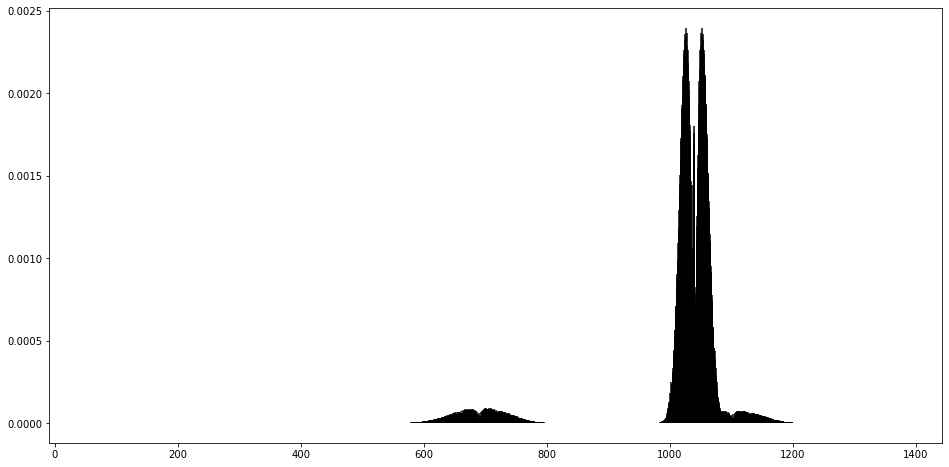

In [35]:
Pos = np.concatenate((P_nu1, Q_nu1, R_nu1, P_nu2, Q_nu2, R_nu2, P_nu3, Q_nu3, R_nu3))
Pos = np.reshape(Pos, (len(Pos),1))
Int = np.concatenate((Final_I[0], Final_I[1], Final_I[2], Final_I[3], Final_I[4], Final_I[5], Final_I[6], Final_I[7], Final_I[8]))
Int = np.reshape(Int, (len(Int),1))
Pos_and_Int = np.concatenate((Pos,Int), axis=1)
np.savetxt("O3_666_13DaLo_outputdata_WN_and_INT.txt", Pos_and_Int, delimiter=",")
#Quick double check of the data saved
plt.figure(figsize=(16,8))
plt.vlines(Pos_and_Int[:,0],0,Pos_and_Int[:,1])